In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mushroom-classification/mushrooms.csv


In [2]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 4.6 MB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=90f00869bc9d84c08d8d6cd2e69c3b981893cc40a59b9f9fc0842729316e2f99
  Stored in directory: /root/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus


In [3]:
import itertools
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,OneHotEncoder
from sklearn.compose import ColumnTransformer
from io import StringIO
from IPython.display import Image,display_html
from sklearn import tree
import pydotplus
import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
import statsmodels.api as sm
import scipy.stats as ss


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since 

In [4]:
RS=405
pd.set_option('max_columns',25)
shap.initjs()

In [5]:
mush=pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv',dtype='category')
mush.columns=mush.columns.str.replace('-','_')
mush.rename(columns={'class':'toxic'},inplace=True)

In [6]:
mush.head()

toxic cap_shape cap_surface cap_color bruises odor gill_attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color stalk_shape stalk_root  \
0            c         n          k           e          e   
1            c         b          k           e          c   
2            c         b          n           e          c   
3            c         n          n           e          e   
4            w         b          k           t          e   

  stalk_surface_above_ring stalk_surface_below_ring stalk_color_above_ring  \
0                        s                        s                      w   
1                        s                        s                      w   
2                        s                        s                      w   
3                        s                        s                      w   
4                        s                        s                      w   

  stalk_color_below_ring veil_type veil_color ring_number ring_type  \
0                      w         p          w           o         p   
1                      w         p          w           o         p   
2                      w         p          w           o         p   
3                      w         p          w           o         p   
4                      w         p          w           o         e   

  spore_print_color population habitat  
0                 k          s       u  
1                 n          n       g  
2                 n          n       m  
3                 k          s       u  
4                 n          a       g

Exploratory Data Analysis

In [7]:
mush.toxic.value_counts()

e    4208
p    3916
Name: toxic, dtype: int64

In [8]:
mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
toxic                       8124 non-null category
cap_shape                   8124 non-null category
cap_surface                 8124 non-null category
cap_color                   8124 non-null category
bruises                     8124 non-null category
odor                        8124 non-null category
gill_attachment             8124 non-null category
gill_spacing                8124 non-null category
gill_size                   8124 non-null category
gill_color                  8124 non-null category
stalk_shape                 8124 non-null category
stalk_root                  8124 non-null category
stalk_surface_above_ring    8124 non-null category
stalk_surface_below_ring    8124 non-null category
stalk_color_above_ring      8124 non-null category
stalk_color_below_ring      8124 non-null category
veil_type                   8124 non-null category
veil_color                

In [9]:
mush.stalk_root.value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk_root, dtype: int64

In [10]:
mush.nunique().sort_values(ascending=False)

gill_color                  12
cap_color                   10
spore_print_color            9
odor                         9
stalk_color_below_ring       9
stalk_color_above_ring       9
habitat                      7
population                   6
cap_shape                    6
stalk_root                   5
ring_type                    5
stalk_surface_above_ring     4
stalk_surface_below_ring     4
veil_color                   4
cap_surface                  4
ring_number                  3
stalk_shape                  2
gill_size                    2
gill_spacing                 2
gill_attachment              2
bruises                      2
toxic                        2
veil_type                    1
dtype: int64

In [11]:
mush_enc=mush.drop(columns='veil_type').apply(lambda x:x.cat.codes)

In [12]:
X,y=mush.drop(columns=['toxic','veil_type']),mush.toxic
X_enc,y_enc=X.apply(lambda x:x.cat.codes),y.cat.codes

In [13]:
# categorical encoded dataset
X_train,X_test,y_train,y_test=train_test_split(X_enc,y_enc,test_size=.20,random_state=RS)

In [14]:
#One-hot encoded dataset
Xoh=pd.get_dummies(X,drop_first=False)
Xoh_train,Xoh_test,yoh_train,yoh_test=train_test_split(Xoh,y_enc,test_size=.20,random_state=RS)
X.shape,Xoh.shape

((8124, 21), (8124, 116))

In [15]:
Xoh.head()

cap_shape_b  cap_shape_c  cap_shape_f  cap_shape_k  cap_shape_s  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cap_shape_x  cap_surface_f  cap_surface_g  cap_surface_s  cap_surface_y  \
0            1              0              0              1              0   
1            1              0              0              1              0   
2            0              0              0              1              0   
3            1              0              0              0              1   
4            1              0              0              1              0   

   cap_color_b  cap_color_c  ...  population_c  population_n  population_s  \
0            0            0  ...             0             0             1   
1            0            0  ...             0             1             0   
2            0            0  ...             0             1             0   
3            0            0  ...             0             0             1   
4            0            0  ...             0             0             0   

   population_v  population_y  habitat_d  habitat_g  habitat_l  habitat_m  \
0             0             0          0          0          0          0   
1             0             0          0          1          0          0   
2             0             0          0          0          0          1   
3             0             0          0          0          0          0   
4             0             0          0          1          0          0   

   habitat_p  habitat_u  habitat_w  
0          0          1          0  
1          0          0          0  
2          0          0          0  
3          0          1          0  
4          0          0          0  

[5 rows x 116 columns]

In [16]:
ftnames=X.columns.values#feature names
ftnames_oh=Xoh.columns.values#One-hot encoded feature names

In [17]:
def conditional_entropy(x,y):
    y=y.astype(np.int64)
    y_counter=np.bincount(y)
    xy_counter=Counter(list(zip(x,y)))
    total_occurrences=y_counter.sum()
    entropy=0
    for k,v in xy_counter.items():
        p_xy=v/total_occurrences
        p_y=y_counter[k[1]]/total_occurrences
        entropy +=p_xy*np.log(p_y/p_xy)
    return entropy
def cramers_v(x,y):
    "Calculates Cramer's V statistic for categorical-categorical association.this is a symmetric coefficient:V(x,y)=v(y,x)"
    confusion_matrix=pd.crosstab(x,y)
    chi2=ss.chi2_contingency(confusion_matrix)[0]
    n=confusion_matrix.sum().sum()
    phi2=chi2/n
    r,k=confusion_matrix.shape
    phi2corr=max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr=r-((r-1)**2)/(n-1)
    kcorr=k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def theils_u(x,y):
    """Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
          This is the uncertainity of x given y:value is on the range of [0,1]
             -where 0 means y priovides no information about x,and 1 means y priovides full information about x. This is an asymmetric coefficient :U(x,y)!=U(y,x)"""
    x=x.astype(np.int64)
    s_xy=conditional_entropy(x,y)
    x_counter=np.bincount(x)
    total_occurrences=x_counter.sum()
    p_x=x_counter/total_occurrences
    s_x=ss.entropy(p_x)
    if s_x==0:
        return 1
    return (s_x-s_xy)/s_x
def catcorr(data,method='theils'):
    """Compute categorical correlations using uncertainty coefficients (Theil's U) or Cramer's V"""
    if method=='cramers':
        return data.corr(method=cramers_v)
    elif method !='theils':
        raise NotImplementedError(f"method:'{method}'not implemented,choose either 'cramers'or 'theils'")
        cols=data.columns
        clen=cols.size
        pairings=list(itertools.product(data.columns,repeat=2))
        theils_mat=np.reshape([theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
        return pd.DataFrame(theils_mat,index=cols,columns=cols)
        
        
    

    
    

Models


In [18]:
def multi_table(*dfs):
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [19]:
def pplot_cm(y_true,y_pred,labels=None,filename=None,ymap=None,cf_report=False,figsize=(7,5),**kwargs):
    if ymap is not None:
        y_pred=[ymap[yi] for yi in y_pred]
        y_true=[ymap[yi]for yi in y_true]
        labels=[ymap[yi]for yi in labels]
    if cf_report:
        print(classification_report(y_true,y_pred))
    labels=labels if labels is not None else y_true.unique()
    cm=confusion_matrix(y_true,y_pred,labels=labels)
    cm_sum=np.sum(cm,axis=1,keepdims=True)
    cm_perc=cm/cm_sum.astype(float)*100
    annot=np.empty_like(cm).astype(str)
    nrows,ncols=cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c=cm[i,j]
            p=cm_perc[i,j]
            if i==j:
                s=cm_sum[i]
                annot[i,j]='%.1f%%\n%d/%d'%(p,c,s)
            elif c==0:
                annot[i,j]=''
            else:
                annot[i,j]='%.1f%%\n%d'%(p,c)
    cm=pd.DataFrame(cm,index=labels,columns=labels)
    cm.index.name='Actual'
    cm.columns.name='Predicted'
    fig,ax=plt.subplots(figsize=figsize)
    sns.heatmap(cm,annot=annot,fmt='',ax=ax,**kwargs)
    plt.savefig(filename) if filename is not None else plt.show()

In [20]:
def plot_tree(dtree,featnames,cnames=None,width=600,height=800):
    dot_data=StringIO()
    tree.export_graphviz(dtree,out_file=dot_data,feature_names=featnames,class_names=cnames,filled=True,rounded=True,special_characters=True)
    graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png(),width=width,height=height)

In [21]:
rfc=RandomForestClassifier(100,n_jobs=-1,random_state=RS)
rfc.fit(X_train,y_train)
preds=rfc.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       797

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



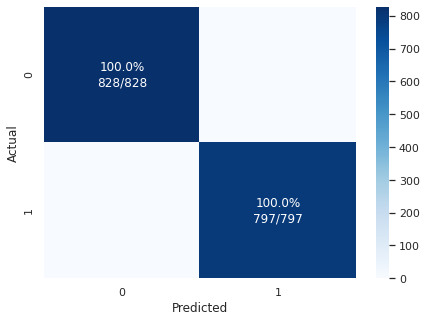

In [22]:
pplot_cm(y_test,preds,rfc.classes_,cf_report=True,figsize=(7,5),cmap='Blues')

In [23]:
skf=StratifiedKFold(5,shuffle=True,random_state=RS)
for train_idx,test_idx in skf.split(X_enc,y_enc):
    X_train,X_test,y_train,y_test=X_enc.loc[train_idx],X_enc.loc[test_idx],y_enc[train_idx],y_enc[test_idx]
    rfc.fit(X_train,y_train)
    y_pred=rfc.predict(X_test)
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       1.00      1.00      1.00       784

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              preci

In [24]:
metrics=['precision','recall','f1','roc_auc']
scores=cross_validate(rfc,X_enc,y_enc,scoring=metrics,cv=10,return_train_score=True,n_jobs=-1)
for m in metrics:
    test_score,train_score=[scores[x] for x in scores.keys() if m in x]
    print(m+':\n','{:>4} train scores:{}'.format('',list(train_score)))
    print('{:>5}test scores :{}'.format('',list(test_score)))
    print('{:>5}test mean:{}'.format('',test_score.mean()))

precision:
      train scores:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test scores :[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9490291262135923, 1.0]
     test mean:0.9949029126213592
recall:
      train scores:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test scores :[0.3469387755102041, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test mean:0.9346938775510203
f1:
      train scores:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test scores :[0.5151515151515151, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9738480697384807, 1.0]
     test mean:0.9488999584889996
roc_auc:
      train scores:[0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test scores :[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
     test mean:1.0


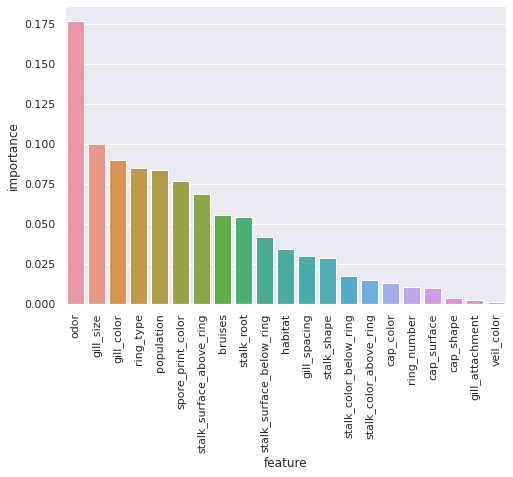

In [25]:
rfc_fi=pd.DataFrame({'feature':X.columns,'importance':rfc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90);

In [26]:
#filter out non perfect scoring decision trees,then take tree with fewest leaves
smallest_dt=min(filter(lambda dt:dt.score(X_test,y_test)==1,rfc.estimators_),key=lambda dt:dt.get_n_leaves())

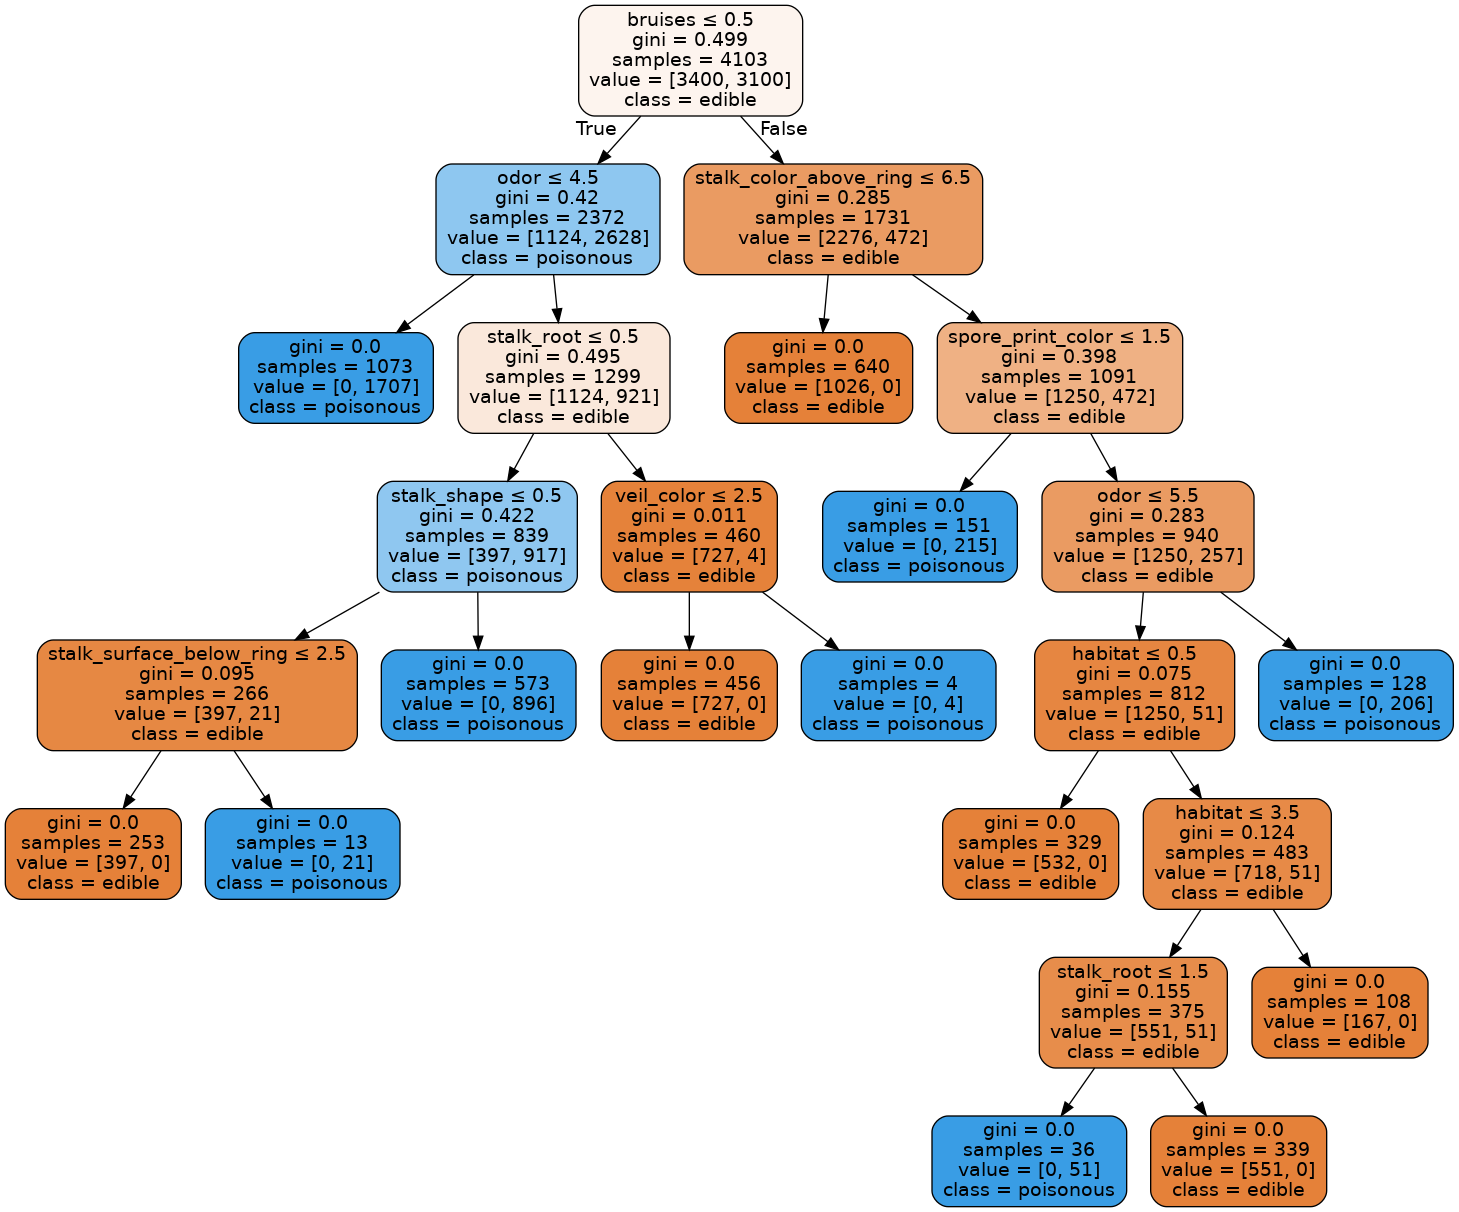

In [27]:
plot_tree(smallest_dt,ftnames,['edible','poisonous'],500,600)

One hot encoded

In [28]:
rfc_oh=RandomForestClassifier(100,n_jobs=-1,random_state=RS)
rfc_oh.fit(Xoh_train,yoh_train)
preds_oh=rfc_oh.predict(Xoh_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       797

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



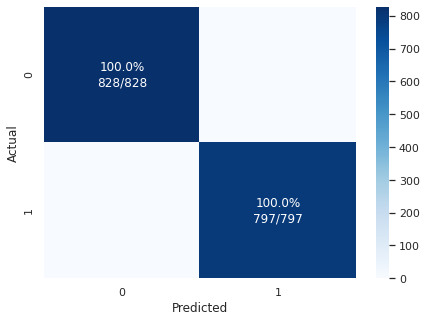

In [29]:
pplot_cm(yoh_test,preds_oh,rfc_oh.classes_,cf_report=True,figsize=(7,5),cmap='Blues')

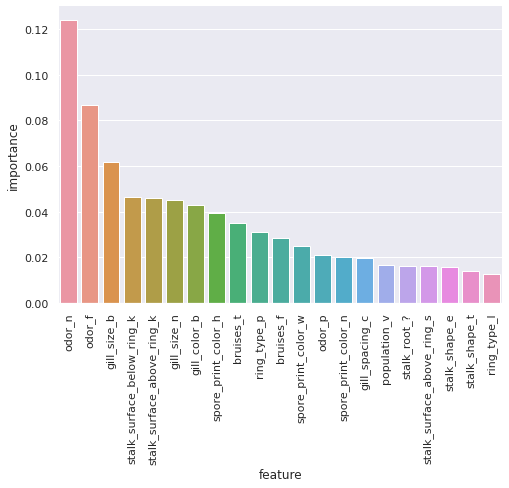

In [30]:
rfc_oh_fi=pd.DataFrame({'feature':Xoh.columns,'importance':rfc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90)

In [31]:
odorXtox=pd.crosstab(mush.odor,mush.toxic)
gsizXtox=pd.crosstab(mush.gill_size,mush.toxic)
gcolXtox=pd.crosstab(mush.gill_color,mush.toxic)
multi_table(odorXtox,gsizXtox,gcolXtox)

toxic 
 e 
 p 
 
 
 odor 
 
 
 
 
 
 
 a 
 400 
 0 
 
 
 c 
 0 
 192 
 
 
 f 
 0 
 2160 
 
 
 l 
 400 
 0 
 
 
 m 
 0 
 36 
 
 
 n 
 3408 
 120 
 
 
 p 
 0 
 256 
 
 
 s 
 0 
 576 
 
 
 y 
 0 
 576 
 
 
 
 
 
 toxic 
 e 
 p 
 
 
 gill_size 
 
 
 
 
 
 
 b 
 3920 
 1692 
 
 
 n 
 288 
 2224 
 
 
 
 
 
 toxic 
 e 
 p 
 
 
 gill_color 
 
 
 
 
 
 
 b 
 0 
 1728 
 
 
 e 
 96 
 0 
 
 
 g 
 248 
 504 
 
 
 h 
 204 
 528 
 
 
 k 
 344 
 64 
 
 
 n 
 936 
 112 
 
 
 o 
 64 
 0 
 
 
 p 
 852 
 640 
 
 
 r 
 0 
 24 
 
 
 u 
 444 
 48 
 
 
 w 
 956 
 246 
 
 
 y 
 64 
 22

In [32]:
smallest_dt_oh=min(filter(lambda dt:dt.score(Xoh_test,yoh_test)==1.0,rfc_oh.estimators_),key=lambda dt:dt.get_n_leaves())

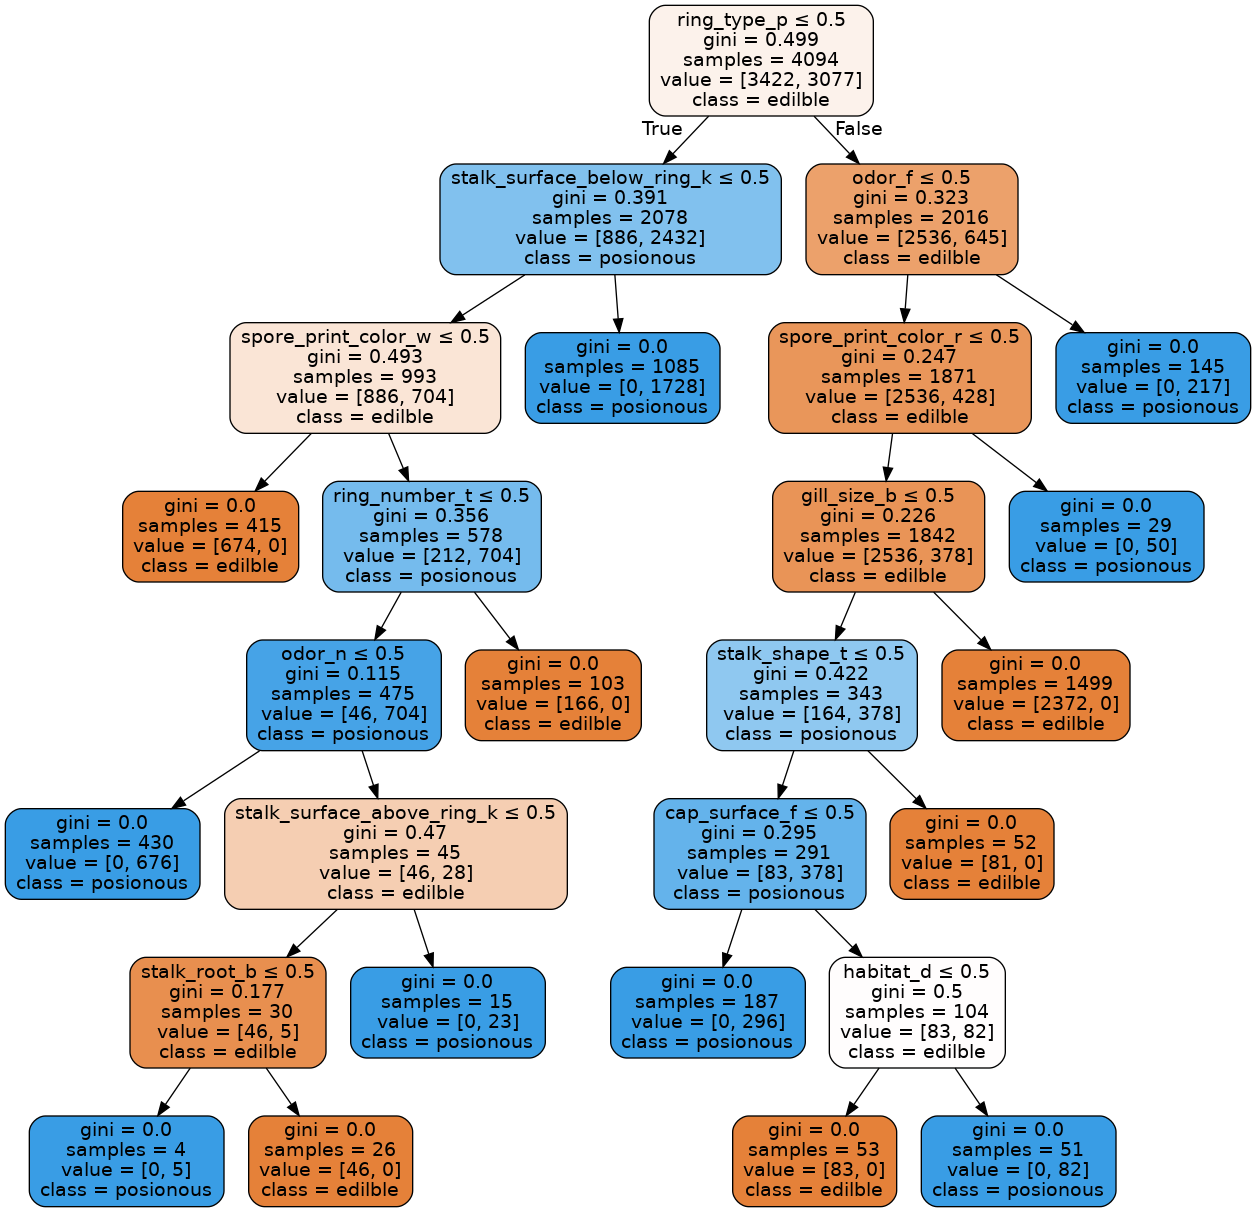

In [33]:
plot_tree(smallest_dt_oh,ftnames_oh,['edilble','posionous'])

XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1624
   macro avg       1.00      1.00      1.00      1624
weighted avg       1.00      1.00      1.00      1624



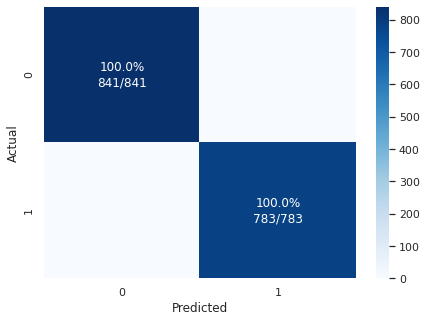

In [34]:
xgbc=xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc.fit(X_train,y_train)
preds=xgbc.predict(X_test)
pplot_cm(y_test,preds,xgbc.classes_,cf_report=True,figsize=(7,5),cmap='Blues')

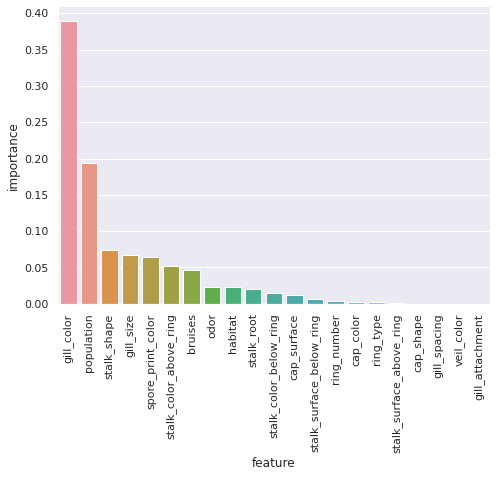

In [35]:
xgbc_fi=pd.DataFrame({'feature':X.columns,'importance':xgbc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       797

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



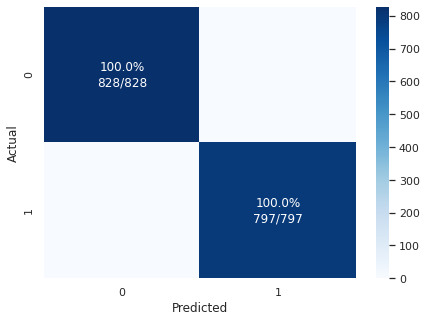

In [36]:
xgbc_oh=xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc_oh.fit(Xoh_train,yoh_train)
preds=xgbc_oh.predict(Xoh_test)
pplot_cm(yoh_test,preds_oh,rfc_oh.classes_,cf_report=True,figsize=(7,5),cmap='Blues')

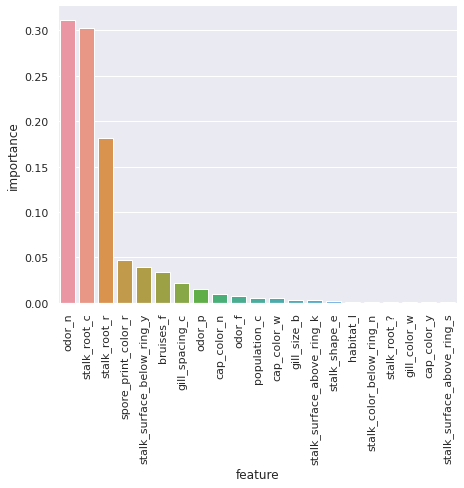

In [37]:
xgbc_oh_fi=pd.DataFrame({'feature':Xoh.columns,'importance':xgbc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90);

Model Exploration

In [38]:
np.random.seed(RS)
RNIDX=np.random.choice(X_test.index)#Random index from test dataset
posidx=X_test.index.get_loc(RNIDX)#positional index within the test dataset of the index label
print(f"Index label(full=split):{RNIDX}\nPostional index (X_test):{posidx}")
(X_enc.loc[RNIDX]==X_test.iloc[posidx]).all()

Index label(full=split):3117
Postional index (X_test):621


True

In [39]:
fi_merge=rfc_fi.merge(xgbc_fi,on='feature',suffixes=('_rf','_xgb')).set_index('feature')
#One-hot encoded feature importances
fi_oh_merge=rfc_oh_fi.merge(xgbc_oh_fi,on='feature',suffixes=('_rf','_xgb')).set_index('feature')
unc_coef=X_enc.corrwith(y_enc,method=theils_u).sort_values(ascending=False)
unc_coef_oh=Xoh.corrwith(y_enc,method=theils_u).sort_values(ascending=False)

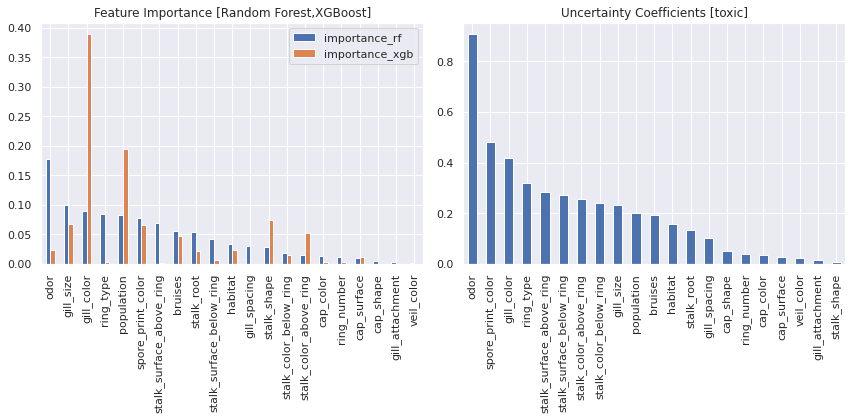

In [40]:
fig,axs=plt.subplots(1,2,figsize=(12,6))
fi_merge.plot.bar(ax=axs[0])
unc_coef.plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest,XGBoost]')
axs[1].set_title('Uncertainty Coefficients [toxic]')
plt.tight_layout()
plt.show()

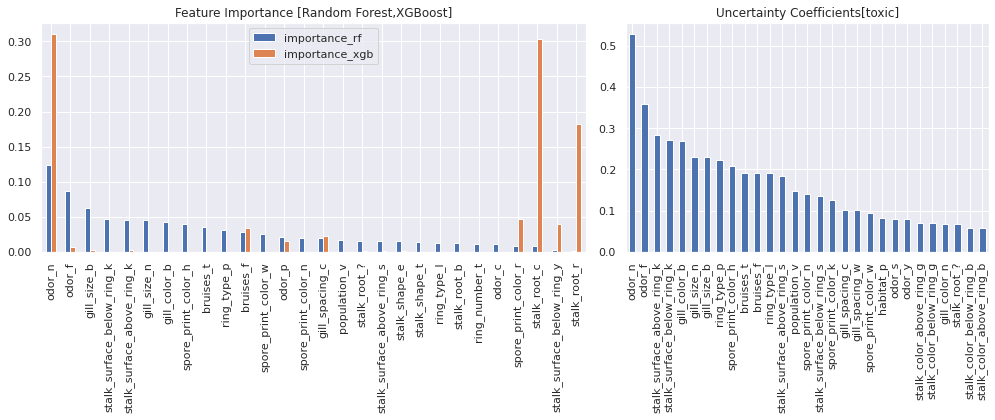

In [41]:
fig,axs=plt.subplots(1,2,figsize=(14,6),gridspec_kw=dict(width_ratios=[3,2]))
fi_oh_merge.query('importance_rf>0.01 | importance_xgb>0.01').plot.bar(ax=axs[0])
#filter out low coefficient values
unc_coef_oh[unc_coef_oh>0.05].plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest,XGBoost]')
axs[1].set_title('Uncertainty Coefficients[toxic]')
plt.tight_layout()

plt.show()

**Permutation Importance******

In [42]:
def multi_eli5(*explainers):
    html_str=''
    for expl in explainers:
        html_str +=expl._repr_html_().replace('style="border-collapse:collapse;','style="display:inline;border-collapse:collapse;')
    display_html(html_str,raw=True)
                                             

Random Forest

In [43]:
rfc_pi=PermutationImportance(rfc,random_state=RS,cv='prefit').fit(X_test,y_test)
rfc_oh_pi=PermutationImportance(rfc_oh,random_state=RS,cv='prefit').fit(Xoh_test,yoh_test)

In [44]:
rfc_weights=eli5.show_weights(rfc,feature_names=ftnames)
rfc_pi_weights=eli5.show_weights(rfc_pi,feature_names=ftnames)

In [45]:
multi_eli5(rfc_weights,rfc_pi_weights)

Weight 
 Feature 
 
 
 
 
 
 
 0.1768
 
 ± 0.3700
 
 
 
 odor
 
 
 
 
 
 0.1000
 
 ± 0.2372
 
 
 
 gill_size
 
 
 
 
 
 0.0902
 
 ± 0.2784
 
 
 
 gill_color
 
 
 
 
 
 0.0849
 
 ± 0.2497
 
 
 
 ring_type
 
 
 
 
 
 0.0835
 
 ± 0.2023
 
 
 
 population
 
 
 
 
 
 0.0770
 
 ± 0.1815
 
 
 
 spore_print_color
 
 
 
 
 
 0.0688
 
 ± 0.2117
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0.0555
 
 ± 0.1811
 
 
 
 bruises
 
 
 
 
 
 0.0543
 
 ± 0.1322
 
 
 
 stalk_root
 
 
 
 
 
 0.0421
 
 ± 0.1560
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0.0341
 
 ± 0.0769
 
 
 
 habitat
 
 
 
 
 
 0.0301
 
 ± 0.1129
 
 
 
 gill_spacing
 
 
 
 
 
 0.0288
 
 ± 0.0893
 
 
 
 stalk_shape
 
 
 
 
 
 0.0175
 
 ± 0.0625
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0.0150
 
 ± 0.0642
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0.0131
 
 ± 0.0281
 
 
 
 cap_color
 
 
 
 
 
 0.0108
 
 ± 0.0386
 
 
 
 ring_number
 
 
 
 
 
 0.0097
 
 ± 0.0350
 
 
 
 cap_surface
 
 
 
 
 
 0.0039
 
 ± 0.0148
 
 
 
 cap_shape
 
 
 
 
 
 0.0024
 
 ± 0.0213
 
 
 
 gill_attachment
 
 
 
 
 
 
 
 … 1 more … 
 
 
 
 
 
 
 

 


 

 

 

 

 

 




 



 

 

 

 

 

 


 

 

 

 

 

 


 

 

 

 

 
 
 
 
 Weight 
 Feature 
 
 
 
 
 
 
 0.0064
 
 ± 0.0020
 
 
 
 gill_size
 
 
 
 
 
 0.0038
 
 ± 0.0026
 
 
 
 odor
 
 
 
 
 
 0.0023
 
 ± 0.0025
 
 
 
 spore_print_color
 
 
 
 
 
 0.0001
 
 ± 0.0005
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_surface
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_type
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_number
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 veil_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_root
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 population
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_shape
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 bruises
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 habitat
 
 
 
 
 
 
 
 … 1 more …

In [46]:
eli5.show_prediction(rfc,X_test.loc[RNIDX],feature_names=ftnames,show_feature_values=True)

In [47]:
eli5.show_prediction(rfc_oh,Xoh.loc[RNIDX],feature_names=ftnames_oh,show_feature_values=True,top=20)

XGBoost

In [48]:
xgbc_pi=PermutationImportance(xgbc,random_state=RS,cv='prefit').fit(X_test,y_test)
xgbc_oh_pi=PermutationImportance(xgbc_oh,random_state=RS,cv='prefit').fit(Xoh_test,yoh_test)

In [49]:
multi_eli5(eli5.show_weights(xgbc_pi,feature_names=ftnames),eli5.show_weights(xgbc_oh_pi,feature_names=ftnames_oh))

Weight 
 Feature 
 
 
 
 
 
 
 0.0857
 
 ± 0.0122
 
 
 
 gill_size
 
 
 
 
 
 0.0724
 
 ± 0.0034
 
 
 
 spore_print_color
 
 
 
 
 
 0.0637
 
 ± 0.0086
 
 
 
 gill_color
 
 
 
 
 
 0.0619
 
 ± 0.0086
 
 
 
 odor
 
 
 
 
 
 0.0190
 
 ± 0.0027
 
 
 
 population
 
 
 
 
 
 0.0128
 
 ± 0.0018
 
 
 
 stalk_shape
 
 
 
 
 
 0.0092
 
 ± 0.0011
 
 
 
 ring_number
 
 
 
 
 
 0.0041
 
 ± 0.0015
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0.0027
 
 ± 0.0006
 
 
 
 stalk_root
 
 
 
 
 
 0.0016
 
 ± 0.0006
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0.0010
 
 ± 0.0013
 
 
 
 habitat
 
 
 
 
 
 0.0005
 
 ± 0.0005
 
 
 
 cap_surface
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 veil_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 bruises
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_type
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_color
 
 
 
 
 
 
 
 … 1 more … 
 
 
 
 
 
 
 

 


 

 

 

 

 

 




 



 

 

 

 

 

 


 

 

 

 

 

 


 

 

 

 

 
 
 
 
 Weight 
 Feature 
 
 
 
 
 
 
 0.4144
 
 ± 0.0169
 
 
 
 odor_n
 
 
 
 
 
 0.0645
 
 ± 0.0048
 
 
 
 bruises_f
 
 
 
 
 
 0.0236
 
 ± 0.0023
 
 
 
 stalk_root_c
 
 
 
 
 
 0.0171
 
 ± 0.0014
 
 
 
 spore_print_color_r
 
 
 
 
 
 0.0149
 
 ± 0.0032
 
 
 
 gill_spacing_c
 
 
 
 
 
 0.0095
 
 ± 0.0046
 
 
 
 gill_size_b
 
 
 
 
 
 0.0043
 
 ± 0.0000
 
 
 
 stalk_surface_below_ring_y
 
 
 
 
 
 0.0018
 
 ± 0.0000
 
 
 
 population_c
 
 
 
 
 
 0.0001
 
 ± 0.0005
 
 
 
 stalk_root_r
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment_f
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing_w
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_p
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_b
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_e
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_g
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_h
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_k
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment_a
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_size_n
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 habitat_w
 
 
 
 
 
 
 
 … 96 more …

LIME(Local Interpretable Model-Agnostic Explanation)

In [50]:
catname_map={i:X[c].cat.categories.values for i,c in enumerate(X)}


In [51]:
def strip_html(htmldoc,strip_tags=['html','meta','head','body'],outfile=None,verbose=False):
    """Strip out HTML boilerplate tags but perserve inner content Only will strip out the first occurrence of each tag ,if multiple occurences are desired,function must be modified."""
    from bs4 import BeautifulSoup
    soup=BeautifulSoup(htmldoc)
    for tag in strip_tags:
        rmtag=soup.find(tag)
        if rmtag is not None:
            rmtag.unwrap()
            if verbose:print(tag,'tags removed')
    stripped=soup.prettify()
    if outfile is not None:
        with open(outfile,'w',encoding='utf-8') as f:
            f.write(stripped)
            if verbose:
                print(f'file saved to:{outfile}')
    else:
        return stripped

In [52]:
limeparams=dict(training_data=X_enc.values,
                training_labels=y_enc.values,
               feature_names=ftnames,
               categorical_features=range(X.shape[1]),
               categorical_names=catname_map,
               class_names=['edible','poisonous'])
lte=lime.lime_tabular.LimeTabularExplainer(**limeparams)

In [53]:
limeparams_oh=dict(training_data=Xoh.values,
                  training_labels=y_enc.values,
                  feature_names=ftnames_oh,categorical_features=range(Xoh.shape[1]),class_names=['edible','poisonous'])
lte_oh=lime.lime_tabular.LimeTabularExplainer(**limeparams_oh)

In [54]:
lte_expl=lte.explain_instance(X_test.loc[RNIDX],rfc.predict_proba)
display_html(strip_html(lte_expl.as_html()),raw=True)

In [55]:
lte_expl_oh=lte_oh.explain_instance(Xoh.loc[RNIDX],rfc_oh.predict_proba)
display_html(strip_html(lte_expl_oh.as_html()),raw=True)

SHAP(SHapley Additive exPlanations)

In [56]:
yv=y_enc[RNIDX];yv #True label of y @ RNIDX for indexing shap valeus

0

In [57]:
shap_xgbc=shap.TreeExplainer(xgbc)
shapvals_xgbc=shap_xgbc.shap_values(X_test,y_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [58]:
shap.force_plot(shap_xgbc.expected_value,shapvals_xgbc[posidx],features=X.loc[RNIDX],link='logit')

In [59]:
fp_glb=shap.force_plot(shap_xgbc.expected_value,shapvals_xgbc[:25],features=X.iloc[:25],out_names='toxic',link='logit')
display_html(fp_glb.data,raw=True)

Visualization omitted, Javascript library not loaded! 
 Have you run `initjs()` in this notebook? If this notebook was from another
 user you must also trust this notebook (File -> Trust notebook). If you are viewing
 this notebook on github the Javascript has been stripped for security. If you are using
 JupyterLab this error is because a JupyterLab extension has not yet been written.

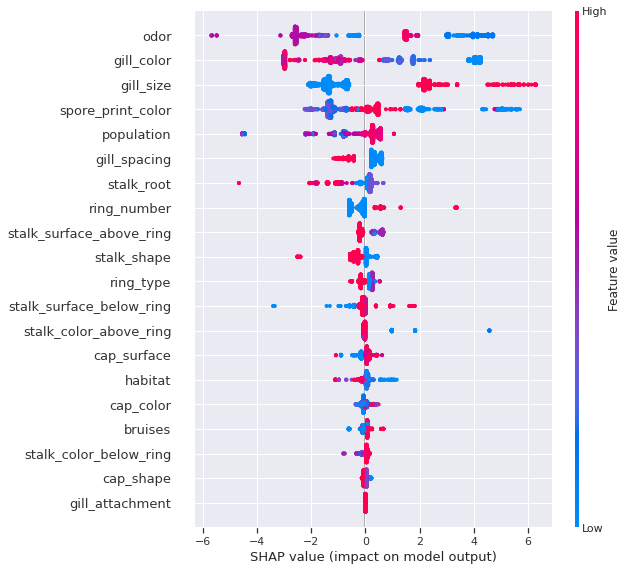

In [60]:
shap.summary_plot(shapvals_xgbc,X_test,feature_names=ftnames,class_names=['edible','poisonous'])

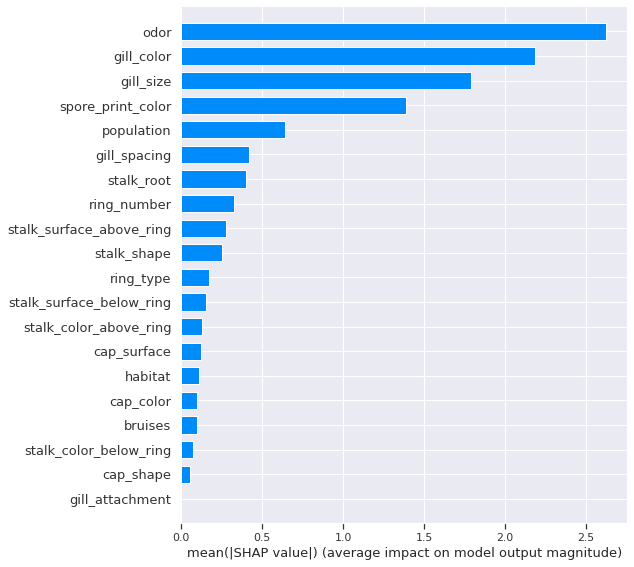

In [61]:
shap.summary_plot(shapvals_xgbc,X_test,feature_names=ftnames,class_names=['edible','poisonous'],plot_type='bar')

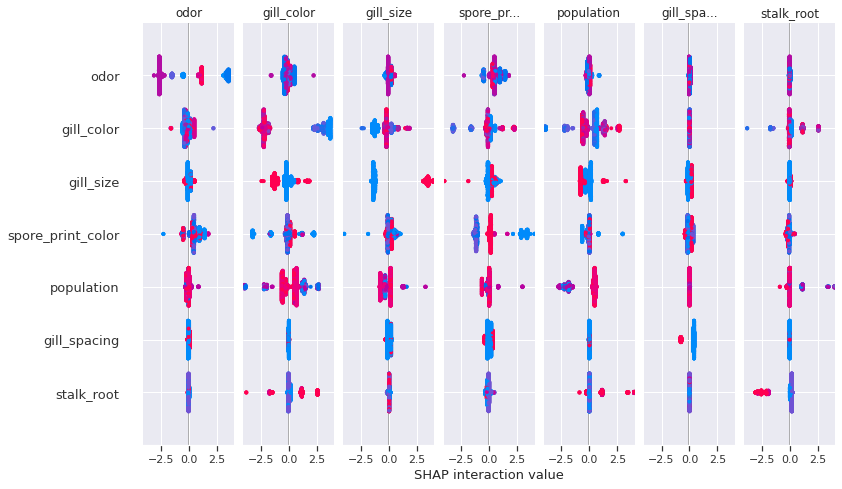

In [62]:
siv_xgbc=shap_xgbc.shap_interaction_values(X_test)
shap.summary_plot(siv_xgbc,X_test)

In [63]:
from shap.plots.dependence import *
def dependence_plot(ind, shap_values, features, feature_names=None, display_features=None,
                    interaction_index="auto",
                    color="#1E88E5", axis_color="#333333", cmap=None,
                    dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True):
    """ Create a SHAP dependence plot, colored by an interaction feature.
    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of the classical parital dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.
    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the name of the feature to plot, or it can have the form "rank(int)" to specify
        the feature with that rank (ordered by mean absolute SHAP value over all the samples).
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features).
    features : numpy.array or pandas.DataFrame
        Matrix of feature values (# samples x # features).
    feature_names : list
        Names of the features (length # features).
    display_features : numpy.array or pandas.DataFrame
        Matrix of feature values for visual display (such as strings instead of coded values).
    interaction_index : "auto", None, int, or string
        The index of the feature used to color the plot. The name of a feature can also be passed
        as a string. If "auto" then shap.common.approximate_interactions is used to pick what
        seems to be the strongest interaction (note that to find to true stongest interaction you
        need to compute the SHAP interaction values).
        
    x_jitter : float (0 - 1)
        Adds random jitter to feature values. May increase plot readability when feature
        is discrete.
    alpha : float
        The transparency of the data points (between 0 and 1). This can be useful to the
        show density of the data points when using a large dataset.
    xmin : float or string
        Represents the lower bound of the plot's x-axis. It can be a string of the format
        "percentile(float)" to denote that percentile of the feature's value used on the x-axis.
    xmax : float or string
        Represents the upper bound of the plot's x-axis. It can be a string of the format
        "percentile(float)" to denote that percentile of the feature's value used on the x-axis.
    ax : matplotlib Axes object
         Optionally specify an existing matplotlib Axes object, into which the plot will be placed.
         In this case we do not create a Figure, otherwise we do.
    """

    if cmap is None:
        cmap = colors.red_blue
        
    # create a matplotlib figure, if `ax` hasn't been specified.
    if not ax:
        figsize = (7.5, 5) if interaction_index != ind else (6, 5)
        fig = pl.figure(figsize=figsize)
        ax = fig.gca()
    else:
        fig = ax.get_figure()

    # convert from DataFrames if we got any
    if str(type(features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    if str(type(display_features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = display_features.columns
        display_features = display_features.values
    elif display_features is None:
        display_features = features

    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1])]

    # allow vectors to be passed
    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, len(shap_values), 1)
    if len(features.shape) == 1:
        features = np.reshape(features, len(features), 1)

    ind = convert_name(ind, shap_values, feature_names)
    
    # plotting SHAP interaction values
    if len(shap_values.shape) == 3 and len(ind) == 2:
        ind1 = convert_name(ind[0], shap_values, feature_names)
        ind2 = convert_name(ind[1], shap_values, feature_names)
        if ind1 == ind2:
            proj_shap_values = shap_values[:, ind2, :]
        else:
            proj_shap_values = shap_values[:, ind2, :] * 2  # off-diag values are split in half

        # TODO: remove recursion; generally the functions should be shorter for more maintainable code
        dependence_plot(
            ind1, proj_shap_values, features, feature_names=feature_names,
            interaction_index=ind2, display_features=display_features, ax=ax, show=False,
            xmin=xmin, xmax=xmax
        )
        if ind1 == ind2:
            ax.set_ylabel(labels['MAIN_EFFECT'] % feature_names[ind1])
        else:
            ax.set_ylabel(labels['INTERACTION_EFFECT'] % (feature_names[ind1], feature_names[ind2]))

        if show:
            pl.show()
        return

    assert shap_values.shape[0] == features.shape[0], \
        "'shap_values' and 'features' values must have the same number of rows!"
    assert shap_values.shape[1] == features.shape[1], \
        "'shap_values' must have the same number of columns as 'features'!"

    # get both the raw and display feature values
    oinds = np.arange(shap_values.shape[0]) # we randomize the ordering so plotting overlaps are not related to data ordering
    np.random.shuffle(oinds)
    xv = features[oinds, ind].astype(np.float64)
    xd = display_features[oinds, ind]
    s = shap_values[oinds, ind]
    if type(xd[0]) == str:
        name_map = {}
        for i in range(len(xv)):
            name_map[xd[i]] = xv[i]
        xnames = list(name_map.keys())

    # allow a single feature name to be passed alone
    if type(feature_names) == str:
        feature_names = [feature_names]
    name = feature_names[ind]

    # guess what other feature as the stongest interaction with the plotted feature
    if interaction_index == "auto":
        interaction_index = approximate_interactions(ind, shap_values, features)[0]
    interaction_index = convert_name(interaction_index, shap_values, feature_names)
    categorical_interaction = False

    # get both the raw and display color values
    color_norm = None
    if interaction_index is not None:
        cv = features[:, interaction_index]
        cd = display_features[:, interaction_index]
        clow = np.nanpercentile(cv.astype(np.float), 5)
        chigh = np.nanpercentile(cv.astype(np.float), 95)
        if type(cd[0]) == str:
            cname_map = {}
            for i in range(len(cv)):
                cname_map[cd[i]] = cv[i]
            cnames = list(cname_map.keys())
            categorical_interaction = True
        elif clow % 1 == 0 and chigh % 1 == 0 and chigh - clow < 10:
            categorical_interaction = True

        # discritize colors for categorical features
        if categorical_interaction and clow != chigh:
            clow = np.nanmin(cv.astype(np.float))
            chigh = np.nanmax(cv.astype(np.float))
            bounds = np.linspace(clow, chigh, int(chigh - clow + 2))
            color_norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N-1)

    # optionally add jitter to feature values
    if x_jitter > 0:
        if x_jitter > 1: x_jitter = 1
        xvals = xv.copy()
        if isinstance(xvals[0], float):
            xvals = xvals.astype(np.float)
            xvals = xvals[~np.isnan(xvals)]
        xvals = np.unique(xvals)
        if len(xvals) >= 2:
            smallest_diff = np.min(np.diff(np.sort(xvals)))
            jitter_amount = x_jitter * smallest_diff
            xv += (np.random.ranf(size = len(xv))*jitter_amount) - (jitter_amount/2)

    # the actual scatter plot, TODO: adapt the dot_size to the number of data points?
    xv_nan = np.isnan(xv)
    xv_notnan = np.invert(xv_nan)
    if interaction_index is not None:

        # plot the nan values in the interaction feature as grey
        cvals = features[oinds, interaction_index].astype(np.float64)
        cvals_imp = cvals.copy()
        cvals_imp[np.isnan(cvals)] = (clow + chigh) / 2.0
        cvals[cvals_imp > chigh] = chigh
        cvals[cvals_imp < clow] = clow
        p = ax.scatter(
            xv[xv_notnan], s[xv_notnan], s=dot_size, linewidth=0, c=cvals[xv_notnan],
            cmap=cmap, alpha=alpha, vmin=clow, vmax=chigh,
            norm=color_norm, rasterized=len(xv) > 500
        )
        p.set_array(cvals[xv_notnan])
    else:
        p = ax.scatter(xv, s, s=dot_size, linewidth=0, color=color,
                       alpha=alpha, rasterized=len(xv) > 500)

    if interaction_index != ind and interaction_index is not None:
        # draw the color bar
        if type(cd[0]) == str:
            tick_positions = [cname_map[n] for n in cnames]
            if len(tick_positions) == 2:
                tick_positions[0] -= 0.25
                tick_positions[1] += 0.25
            cb = pl.colorbar(p, ticks=tick_positions)
            cb.set_ticklabels(cnames)
        else:
            cb = pl.colorbar(p)

        cb.set_label(feature_names[interaction_index], size=13)
        cb.ax.tick_params(labelsize=11)
        if categorical_interaction:
            cb.ax.tick_params(length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.7) * 20)

    # handles any setting of xmax and xmin
    # note that we handle None,float, or "percentile(float)" formats
    if xmin is not None or xmax is not None:
        if type(xmin) == str and xmin.startswith("percentile"):
            xmin = np.nanpercentile(xv, float(xmin[11:-1]))
        if type(xmax) == str and xmax.startswith("percentile"):
            xmax = np.nanpercentile(xv, float(xmax[11:-1]))

        if xmin is None or xmin == np.nanmin(xv):
            xmin = np.nanmin(xv) - (xmax - np.nanmin(xv))/20
        if xmax is None or xmax == np.nanmax(xv):
            xmax = np.nanmax(xv) + (np.nanmax(xv) - xmin)/20
        
        ax.set_xlim(xmin, xmax)

    # plot any nan feature values as tick marks along the y-axis
    xlim = ax.get_xlim()
    if interaction_index is not None:
        p = ax.scatter(
            xlim[0] * np.ones(xv_nan.sum()), s[xv_nan], marker=1,
            linewidth=2, c=cvals_imp[xv_nan], cmap=cmap, alpha=alpha,
            vmin=clow, vmax=chigh
        )
        p.set_array(cvals[xv_nan])
    else:
        ax.scatter(
            xlim[0] * np.ones(xv_nan.sum()), s[xv_nan], marker=1,
            linewidth=2, color=color, alpha=alpha
        )
    ax.set_xlim(xlim)

    # make the plot more readable
    ax.set_xlabel(name, color=axis_color, fontsize=13)
    ax.set_ylabel(labels['VALUE_FOR'] % name, color=axis_color, fontsize=13)
    if title is not None:
        ax.set_title(title, color=axis_color, fontsize=13)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(color=axis_color, labelcolor=axis_color, labelsize=11)
    for spine in ax.spines.values():
        spine.set_edgecolor(axis_color)
    if type(xd[0]) == str:
        ax.set_xticks([name_map[n] for n in xnames])
        ax.set_xticklabels(xnames, dict(rotation='vertical', fontsize=11))
    if show:
        with warnings.catch_warnings(): # ignore expected matplotlib warnings
            warnings.simplefilter("ignore", RuntimeWarning)
            pl.show()

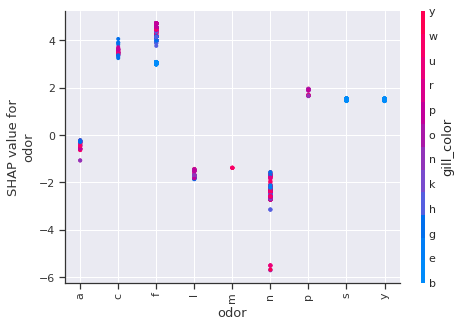

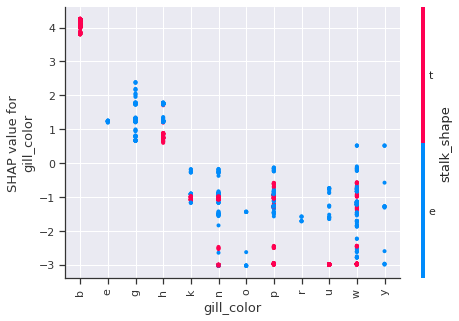

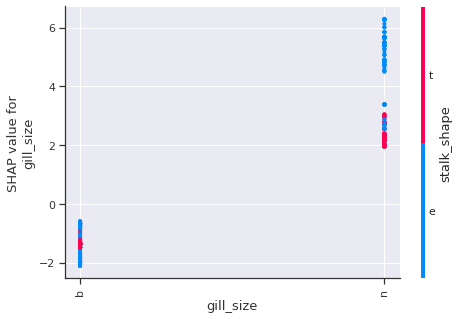

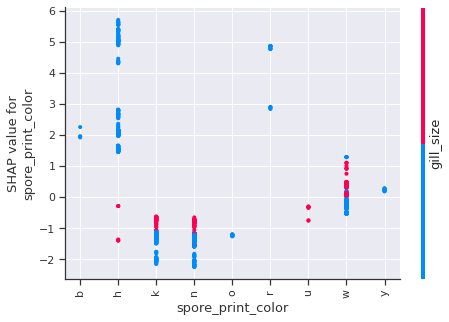

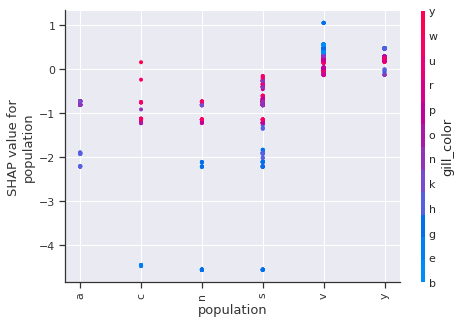

In [64]:
for i in range(5):
    dependence_plot(f'rank({i})',shapvals_xgbc,X_test,display_features=X.loc[X_test.index])

Manual Modeling

In [65]:
pd.crosstab(mush.odor,[mush.toxic])


toxic     e     p
odor             
a       400     0
c         0   192
f         0  2160
l       400     0
m         0    36
n      3408   120
p         0   256
s         0   576
y         0   576

In [66]:
def toxcor(X):
    return X.drop('toxic',1).apply(lambda x:x.cat.codes).corrwith(X.toxic.cat.codes,method=theils_u).sort_values(ascending=False)

In [67]:
odorN=mush[mush.odor=="n"].drop('veil_type',1)

In [68]:
toxcor(odorN)

spore_print_color           6.768442e-01
cap_color                   4.371612e-01
gill_color                  4.027649e-01
stalk_shape                 2.916187e-01
stalk_color_below_ring      2.833743e-01
habitat                     2.761553e-01
stalk_surface_below_ring    2.383585e-01
population                  2.048373e-01
cap_shape                   1.992199e-01
stalk_color_above_ring      1.688005e-01
stalk_root                  1.135320e-01
ring_number                 1.118555e-01
stalk_surface_above_ring    1.112397e-01
gill_size                   1.092590e-01
cap_surface                 7.508798e-02
veil_color                  6.435305e-02
gill_spacing                2.155632e-02
gill_attachment             1.305308e-02
bruises                     4.093762e-03
ring_type                   3.767631e-03
odor                        3.739931e-16
dtype: float64

In [69]:
pd.crosstab([odorN.toxic],[odorN.spore_print_color])

spore_print_color   b   h     k     n   o   r    w   y
toxic                                                 
e                  48  48  1296  1344  48   0  576  48
p                   0   0     0     0   0  72   48   0

In [70]:
odorN_spcW=odorN[odorN.spore_print_color=='w']


In [71]:
toxcor(odorN_spcW)

habitat                     0.669041
ring_number                 0.606777
gill_size                   0.606777
stalk_surface_below_ring    0.570277
cap_color                   0.543356
stalk_color_below_ring      0.528912
population                  0.305571
gill_color                  0.232560
cap_surface                 0.227199
stalk_surface_above_ring    0.184856
stalk_color_above_ring      0.174359
stalk_root                  0.125971
veil_color                  0.125133
ring_type                   0.096877
cap_shape                   0.084574
gill_spacing                0.033172
bruises                     0.030977
stalk_shape                 0.000000
gill_attachment             0.000000
odor                        0.000000
spore_print_color           0.000000
dtype: float64

In [72]:
odorN_spcW_habLD=odorN_spcW[odorN_spcW.habitat.isin(['l','d'])]

In [73]:
toxcor(odorN_spcW_habLD)

stalk_root                  0.664063
stalk_surface_above_ring    0.594799
cap_color                   0.574353
stalk_color_below_ring      0.468665
stalk_surface_below_ring    0.448007
population                  0.249910
gill_spacing                0.219754
habitat                     0.219754
stalk_color_above_ring      0.155288
cap_shape                   0.133864
veil_color                  0.091625
bruises                     0.091625
cap_surface                 0.084183
ring_number                 0.072962
gill_size                   0.072962
gill_color                  0.044391
ring_type                   0.000782
stalk_shape                 0.000000
gill_attachment             0.000000
odor                        0.000000
spore_print_color           0.000000
dtype: float64

In [74]:
pd.crosstab([odorN_spcW_habLD.toxic],[odorN_spcW_habLD.stalk_root],)

stalk_root   ?   b  c
toxic                
e            0  56  0
p           32   8  8

In [75]:
odorN_spcW_habLD_stkB=odorN_spcW_habLD[odorN_spcW_habLD.stalk_root=='b']

In [76]:
toxcor(odorN_spcW_habLD_stkB)

cap_color                   1.000000e+00
bruises                     1.000000e+00
stalk_color_below_ring      1.000000e+00
population                  1.000000e+00
ring_type                   5.400729e-01
cap_surface                 5.000000e-01
cap_shape                   3.457588e-01
stalk_surface_below_ring    2.537425e-01
stalk_surface_above_ring    2.537425e-01
gill_size                   4.755786e-02
gill_spacing                4.755786e-02
habitat                     4.755786e-02
stalk_color_above_ring      4.755786e-02
ring_number                 4.755786e-02
gill_color                  1.473343e-16
stalk_shape                 1.473343e-16
gill_attachment             1.473343e-16
odor                        1.473343e-16
veil_color                  1.473343e-16
spore_print_color           1.473343e-16
stalk_root                  1.473343e-16
dtype: float64

In [77]:
pd.crosstab([odorN_spcW_habLD_stkB.toxic],[odorN_spcW_habLD_stkB.cap_color])

cap_color   c   n  w
toxic               
e          24  32  0
p           0   0  8

In [78]:
def logic_tree(X):
    preds=[]
    for i,r in X.iterrows():
        if r.odor in ['a','l']:
            preds.append(0)
        elif r.odor=='n':
            if r.spore_print_color=='r':
                preds.append(1)
            elif r.spore_print_color=='w':
                if r.habitat not in ['l','d']:
                    preds.append(0)
                else:
                    if r.stalk_root!='b':
                            preds.append(1)
                    else:
                        preds.append(1 if r.cap_color=='w' else 0)
            else:
                preds.append(0)
        else:
            preds.append(1)
    return preds
                    

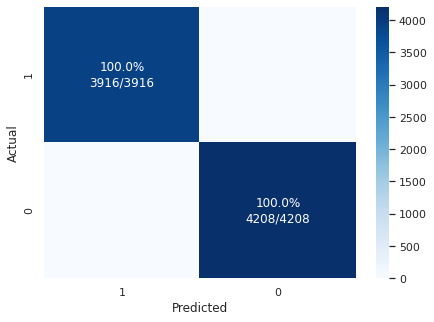

In [79]:
ltpreds=logic_tree(X)
pplot_cm(y_enc,ltpreds,cmap='Blues')

References
1.https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7

2.https://xgboost.readthedocs.io/en/latest/get_started.html

3.https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

4.https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

5.https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html